In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import collections
import statistics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# Algorithms used for modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier

/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Read data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Cleaning
First take care of null values

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Only Age and Cabin have considerable missing values. Lets first take care of Age. I will try and make an educated guess for the missing age values based on the name column

# 1. Data Cleaning
## 1.1 Titles

In [7]:
train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

I will try and extract the title from the Name column (Mr, Mrs, Miss etc) and assign an appropriate age based on the title.

In [8]:
#define function for creating Title column in df
def get_title(df):
    titles = list()
    name_list = df['Name']
    for name in name_list:
        #extract title
        match = re.search(",([^.]*)",name)
        #clean title
        match = re.sub(",\s",'',str(match.group()))
        #add title to list
        titles.append(match)
    return titles

In [9]:
train['Title'] = get_title(train)

In [10]:
test['Title'] = get_title(test)

Now lets plot histograms of each of the titles and age

In [11]:
all_titles = train['Title'].unique()

In [12]:
#define function to get age list for histogram
def get_lists(title,df):
    age_list = list()
    for x in range(len(df)):
        if ((df.loc[x,'Title'] == title)):
            age_list.append(df.loc[x,'Age'])
    return age_list
            

In [13]:
#define function to plot all histograms
def plot_hist(df,all_titles):
    for title in all_titles:
        title_list = list()
        title_list = get_lists(title,df)
        title_list = [x for x in title_list if str(x) != 'nan']
        sns.set_style("darkgrid")
        plt.hist(title_list, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        plt.ylabel('Frequency')
        plt.xlabel('Age of person with the ' + title + ' title')
        plt.show()

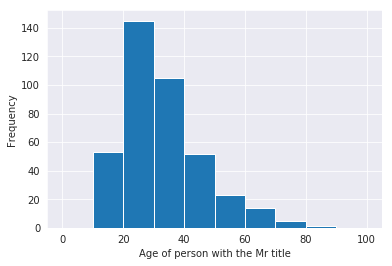

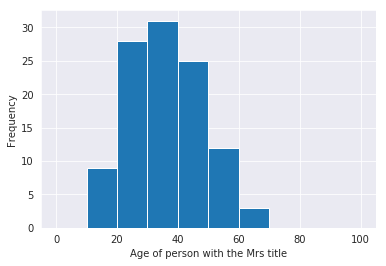

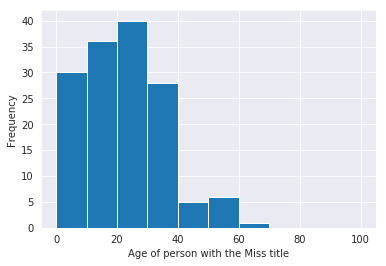

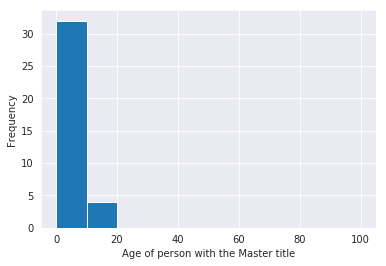

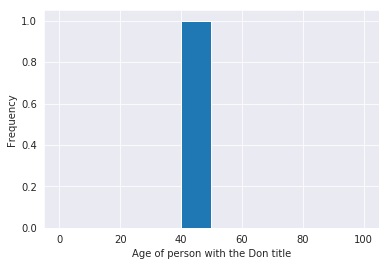

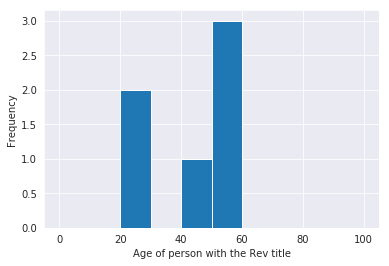

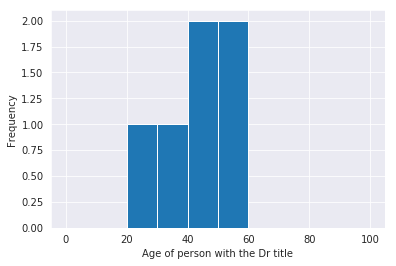

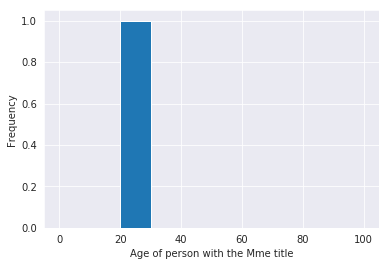

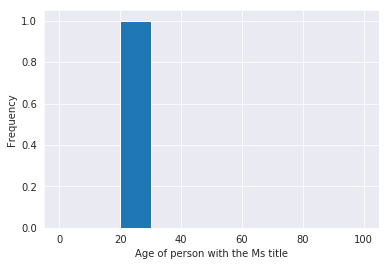

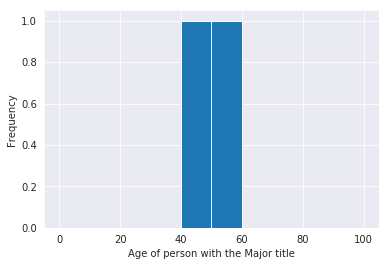

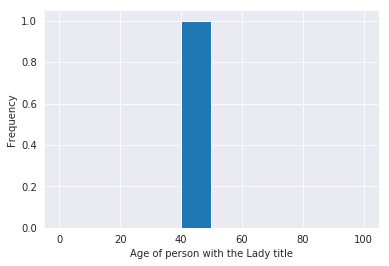

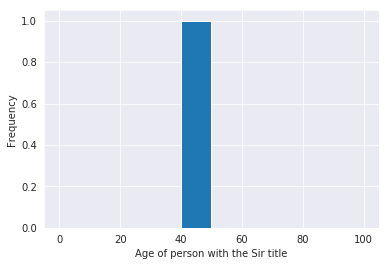

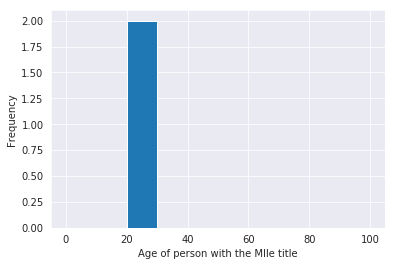

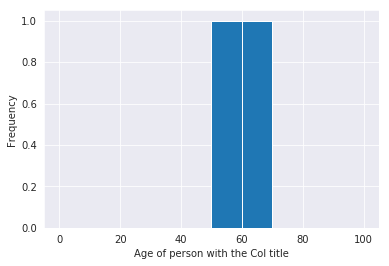

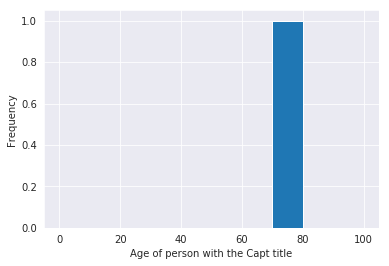

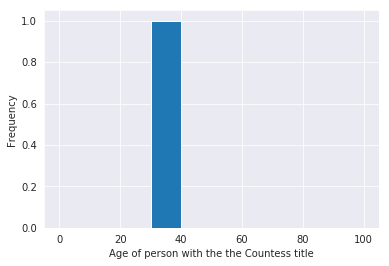

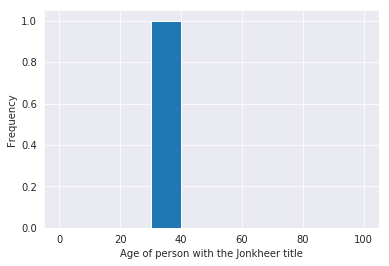

In [14]:
plot_hist(train,all_titles)

I could create bins for the age groups and add each Bin to the dataframes as a bool column, but I'll just round each age down to the closest 10 - effectively doing the same thing while keeping the list of features short. After this I'll fill the missing values with the average of each title. The histograms generally dont seem to be skewed heavily. Let's first see which titles have the most missing age values

In [15]:
missingage_title_list = list() 
for x in range(0,len(train['Age'])):
    age = train.loc[x,'Age']
    if np.isnan(age):
        missingage_title_list.append(str(train.loc[x,'Title']))

In [16]:
counts = collections.Counter(missingage_title_list)
print(counts)

Counter({'Mr': 119, 'Miss': 36, 'Mrs': 17, 'Master': 4, 'Dr': 1})


It seems the majority of missing age values are 'Mr' titles. Lets plot the same histograms for the test data set before we do any treating

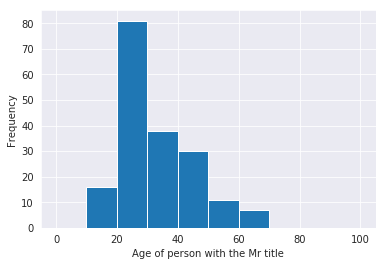

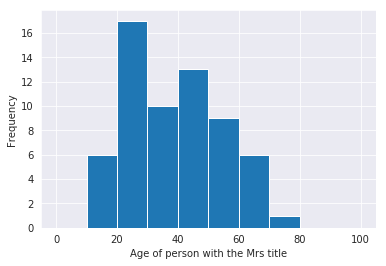

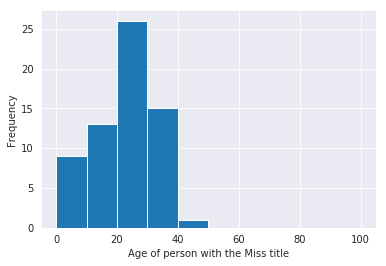

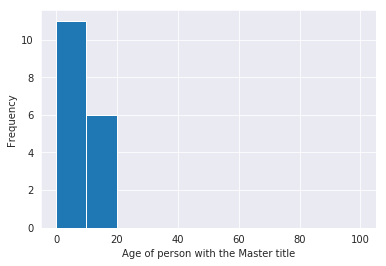

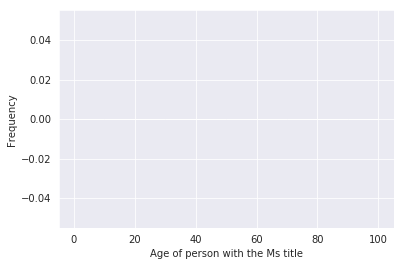

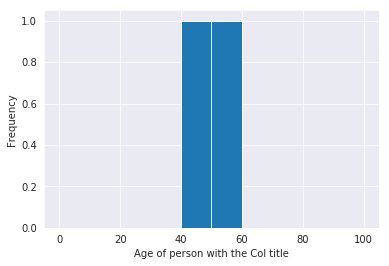

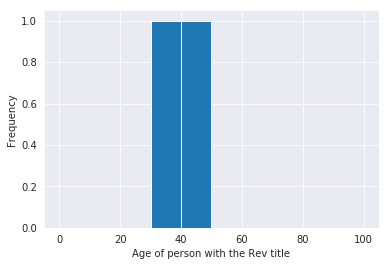

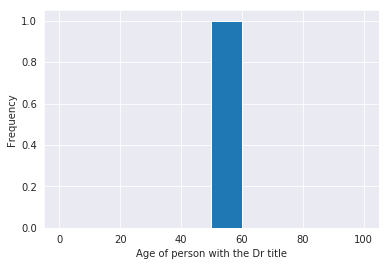

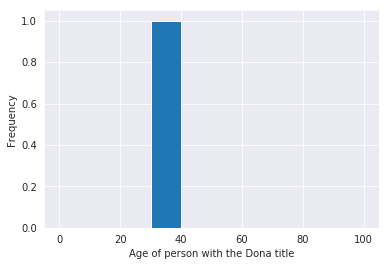

In [17]:
all_titles = test['Title'].unique()
plot_hist(test,all_titles)

In [18]:
missingage_title_list = list() 
for x in range(0,len(test['Age'])):
    age = test.loc[x,'Age']
    if np.isnan(age):
        missingage_title_list.append(str(test.loc[x,'Title']))

In [19]:
counts = collections.Counter(missingage_title_list)
print(counts)

Counter({'Mr': 57, 'Miss': 14, 'Mrs': 10, 'Master': 4, 'Ms': 1})


**It might be a good idea to round all ages down to the nearest 10 and then replot the histograms before treating any missing values**

In [20]:
#define function to round down
def round_down(n):
    divider = 10
    n = n/10
    n = math.floor(n)
    n = n*10
    return n

In [21]:
#define function to round down ages in dataset
def round_ages(df):
    for x in range(0,len(df['Age'])):
        age = df.loc[x,'Age']
        if not np.isnan(age):
            age = round_down(age)
            df.loc[x,'Age'] = age
        

In [22]:
#round down ages in train data
round_ages(train)

In [23]:
train['Age'].head()

0    20.0
1    30.0
2    20.0
3    30.0
4    30.0
Name: Age, dtype: float64

In [24]:
#round down ages in test data
round_ages(test)

In [25]:
test['Age'].head()

0    30.0
1    40.0
2    60.0
3    20.0
4    20.0
Name: Age, dtype: float64

### 1.11 Mr Title
Now lets fill in missing age values in rows with the MR title with the mean of the Mr titles

In [26]:
#define function to fill nan values
def fill_nan(df,title):
    title_mean = df.Age[df["Title"]==title].mean()
    for x in range(0,len(df['Title'])):
        age = df.loc[x,'Age']
        row_title = df.loc[x,'Title']
        if (np.isnan(age) & (row_title==title)):
            df.loc[x,'Age'] = title_mean

In [27]:
#fill missing values for the MR title in train and test
fill_nan(train,'Mr')
fill_nan(test,'Mr')

Now lets recheck our null values

In [28]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             58
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [29]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             29
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

It did the trick. Now lets do the same for the other titles

### 1.12 Miss Title

In [30]:
#fill missing values for the Miss title in train and test
fill_nan(train,'Miss')
fill_nan(test,'Miss')

### 1.13 Mrs Title

In [31]:
#fill missing values for the Mrs title in train and test
fill_nan(train,'Mrs')
fill_nan(test,'Mrs')

### 1.14 Master Title

In [32]:
#fill missing values for the Master title in train and test
fill_nan(train,'Master')
fill_nan(test,'Master')

### 1.15 Ms Title (test) and Dr Title (train)

In [33]:
fill_nan(train,'Dr')
fill_nan(test,'Ms')

Now lets recheck our null values

In [34]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              1
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [35]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

There is still one age value left in the test dataframe because their exists only 1 Ms title, and it is missing. Therefore no mean can be calculated. We will instead fill with the mean of the whole frame.

In [36]:
ms_mean = test['Age'].mean()
#round down the mean
ms_mean = round_down(ms_mean)
ms_mean

20

In [37]:
#fill with mean
test['Age'].fillna(ms_mean, inplace=True)

In [38]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [39]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

## 1.2 Cabin

In [40]:
train['Cabin'].isnull().sum()

687

In [41]:
len(train['Cabin'])

891

The Cabin feature has too many missing values to be of any use and any attempt to fill in these values wouldn't be very accurate. Lets just drop this column all together.

In [42]:
train.drop('Cabin',axis=1,inplace = True)
test.drop('Cabin',axis=1,inplace = True)

In [43]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Title          0
dtype: int64

In [44]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Title          0
dtype: int64

## 1.3 Others
Drop the 2 rows from train with null values and fill the 1 from test with the column mean

In [45]:
#fill with mean
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [46]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

In [47]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Title          0
dtype: int64

In [48]:
train = train.dropna()

In [49]:
#save the ID before dropping
test_Pass_ID = test['PassengerId']
test = test.dropna()

In [50]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

In [51]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,20.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,30.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,20.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,30.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,30.0,0,0,373450,8.0500,S,Mr


In [53]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,30.0,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,40.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,60.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,20.0,0,0,315154,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,20.0,1,1,3101298,12.2875,S,Mrs


Now that all rows are clean, we move on to feature engineering

# 2. Feature Engineering

First, lets drop the Name column and Ticket column as theyre both useless for us

In [54]:
test.drop('Name', axis = 1, inplace = True)
train.drop('Name', axis = 1, inplace = True)

In [55]:
test.drop('Ticket', axis = 1, inplace = True)
train.drop('Ticket', axis = 1, inplace = True)

In [56]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,30.0,0,0,7.8292,Q,Mr
1,893,3,female,40.0,1,0,7.0000,S,Mrs
2,894,2,male,60.0,0,0,9.6875,Q,Mr
3,895,3,male,20.0,0,0,8.6625,S,Mr
4,896,3,female,20.0,1,1,12.2875,S,Mrs


In [57]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,20.0,1,0,7.2500,S,Mr
1,2,1,1,female,30.0,1,0,71.2833,C,Mrs
2,3,1,3,female,20.0,0,0,7.9250,S,Miss
3,4,1,1,female,30.0,1,0,53.1000,S,Mrs
4,5,0,3,male,30.0,0,0,8.0500,S,Mr


## 2.1 Sex
Lets enumerate the Sex column. 0 for female and 1 for male

In [58]:
#dictionary for mapping
sex_dict = {'male': 1, 'female':0}

In [59]:
#map values on test sets
test['Sex'] = test['Sex'].map(sex_dict)
#map values on train sets
train['Sex']=train['Sex'].map(sex_dict)

In [60]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,1,30.0,0,0,7.8292,Q,Mr
1,893,3,0,40.0,1,0,7.0000,S,Mrs
2,894,2,1,60.0,0,0,9.6875,Q,Mr
3,895,3,1,20.0,0,0,8.6625,S,Mr
4,896,3,0,20.0,1,1,12.2875,S,Mrs


In [61]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,20.0,1,0,7.2500,S,Mr
1,2,1,1,0,30.0,1,0,71.2833,C,Mrs
2,3,1,3,0,20.0,0,0,7.9250,S,Miss
3,4,1,1,0,30.0,1,0,53.1000,S,Mrs
4,5,0,3,1,30.0,0,0,8.0500,S,Mr


## 2.2 Fare
Lets just round down this column

In [62]:
#round down train column
fare_list = list()
for fare in train['Fare']:
    fare_list.append(round_down(fare))
    

In [63]:
train['Fare'] = fare_list

In [64]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,20.0,1,0,0,S,Mr
1,2,1,1,0,30.0,1,0,70,C,Mrs
2,3,1,3,0,20.0,0,0,0,S,Miss
3,4,1,1,0,30.0,1,0,50,S,Mrs
4,5,0,3,1,30.0,0,0,0,S,Mr


In [65]:
#round down test column
fare_list = list()
for fare in test['Fare']:
    rounded_fare = round_down(fare)
    fare_list.append(rounded_fare)

In [66]:
test['Fare'].isnull().unique()

array([False])

In [67]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,1,30.0,0,0,7.8292,Q,Mr
1,893,3,0,40.0,1,0,7.0000,S,Mrs
2,894,2,1,60.0,0,0,9.6875,Q,Mr
3,895,3,1,20.0,0,0,8.6625,S,Mr
4,896,3,0,20.0,1,1,12.2875,S,Mrs


## 2.3 Embarked
Also map this just like the Sex column

In [68]:
embarked_dict = {'C' : 0, 'S' : 1, 'Q' : 2}

In [69]:
test['Embarked'] = test['Embarked'].map(embarked_dict)
train['Embarked'] = train['Embarked'].map(embarked_dict)

In [70]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,1,30.0,0,0,7.8292,2,Mr
1,893,3,0,40.0,1,0,7.0000,1,Mrs
2,894,2,1,60.0,0,0,9.6875,2,Mr
3,895,3,1,20.0,0,0,8.6625,1,Mr
4,896,3,0,20.0,1,1,12.2875,1,Mrs


In [71]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,20.0,1,0,0,1,Mr
1,2,1,1,0,30.0,1,0,70,0,Mrs
2,3,1,3,0,20.0,0,0,0,1,Miss
3,4,1,1,0,30.0,1,0,50,1,Mrs
4,5,0,3,1,30.0,0,0,0,1,Mr


## 2.4 Title 
We enumerate this the same way

In [72]:
title_list = list()

In [73]:
train_title_list = train['Title'].unique().tolist()

In [74]:
test_title_list = test['Title'].unique().tolist()

In [75]:
title_list = train_title_list + test_title_list

In [76]:
#change list ot set to remove duplicates
title_set = set(title_list)

In [77]:
title_set

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [78]:
#construct our dictionary
title_dict = {'Capt':0,
 'Col':1,
 'Don':2,
 'Dona':3,
 'Dr':4,
 'Jonkheer':5,
 'Lady':6,
 'Major':7,
 'Master':8,
 'Miss':9,
 'Mlle':10,
 'Mme':11,
 'Mr':12,
 'Mrs':13,
 'Ms':14,
 'Rev':15,
 'Sir':16,
 'the Countess':17}

In [79]:
#map columns
test['Title'] = test['Title'].map(title_dict)
train['Title'] = train['Title'].map(title_dict)

In [80]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,1,30.0,0,0,7.8292,2,12
1,893,3,0,40.0,1,0,7.0000,1,13
2,894,2,1,60.0,0,0,9.6875,2,12
3,895,3,1,20.0,0,0,8.6625,1,12
4,896,3,0,20.0,1,1,12.2875,1,13


In [81]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,20.0,1,0,0,1,12
1,2,1,1,0,30.0,1,0,70,0,13
2,3,1,3,0,20.0,0,0,0,1,9
3,4,1,1,0,30.0,1,0,50,1,13
4,5,0,3,1,30.0,0,0,0,1,12


# 3. Final data prep before modelling

## 3.1 Remove and Save ID

In [82]:
#save then remove the ID Column
train_Pass_ID = train['PassengerId']
test_ID = test['PassengerId']

In [83]:
train.drop('PassengerId',axis = 1, inplace=True)

In [84]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,20.0,1,0,0,1,12
1,1,1,0,30.0,1,0,70,0,13
2,1,3,0,20.0,0,0,0,1,9
3,1,1,0,30.0,1,0,50,1,13
4,0,3,1,30.0,0,0,0,1,12


In [85]:
test.drop('PassengerId',axis = 1, inplace= True)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,1,30.0,0,0,7.8292,2,12
1,3,0,40.0,1,0,7.0000,1,13
2,2,1,60.0,0,0,9.6875,2,12
3,3,1,20.0,0,0,8.6625,1,12
4,3,0,20.0,1,1,12.2875,1,13


## 3.2 Normalize frames

In [86]:
#normalize train
norm_train = (train-train.min())/(train.max()-train.min())

In [87]:
norm_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.0,1.0,1.0,0.250,0.125,0.0,0.000000,0.5,0.705882
1,1.0,0.0,0.0,0.375,0.125,0.0,0.137255,0.0,0.764706
2,1.0,1.0,0.0,0.250,0.000,0.0,0.000000,0.5,0.529412
3,1.0,0.0,0.0,0.375,0.125,0.0,0.098039,0.5,0.764706
4,0.0,1.0,1.0,0.375,0.000,0.0,0.000000,0.5,0.705882


In [88]:
#normalize test
norm_test = (test-test.min())/(test.max()-test.min())
norm_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1.0,1.0,0.428571,0.000,0.000000,0.015282,1.0,0.785714
1,1.0,0.0,0.571429,0.125,0.000000,0.013663,0.5,0.857143
2,0.5,1.0,0.857143,0.000,0.000000,0.018909,1.0,0.785714
3,1.0,1.0,0.285714,0.000,0.000000,0.016908,0.5,0.785714
4,1.0,0.0,0.285714,0.125,0.111111,0.023984,0.5,0.857143


In [89]:
#remove survived from train
y_train = norm_train['Survived']

In [90]:
norm_train.drop('Survived',axis = 1, inplace= True)
norm_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1.0,1.0,0.250,0.125,0.0,0.000000,0.5,0.705882
1,0.0,0.0,0.375,0.125,0.0,0.137255,0.0,0.764706
2,1.0,0.0,0.250,0.000,0.0,0.000000,0.5,0.529412
3,0.0,0.0,0.375,0.125,0.0,0.098039,0.5,0.764706
4,1.0,1.0,0.375,0.000,0.0,0.000000,0.5,0.705882


In [91]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [92]:
#split data for stacking
x_train, x_test, y_train, y_test=train_test_split(norm_train,y_train,test_size=0.3)

# 4. Modelling
We will be stacking predictions from a few base models then use gradient boosting trees to make final predictions for submission on the base models' predictions

In [93]:
#base models
models = [DecisionTreeClassifier(),
GradientBoostingClassifier(),
LogisticRegression(),
MLPClassifier()]

In [94]:
#model names
names = ['DecisionTreeClassifier','GradientBoostingClassifier'
,'LogisticRegression','MLPClassifier','RandomForestClassifier']

In [95]:
#now make parameter grids for all these models. I have hard coded some of the best parameters from a previous
#grid search in order to save time
decisiontree_grid = {'max_depth': [4]}
GB_grid = { "loss":["deviance"],
    "learning_rate": [0.2],
    "min_samples_split": [2],
    "min_samples_leaf": [0.1],
    "max_depth":[3,4],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.8],
    "n_estimators":[10] }
LogReg_grid =  {"C":[1.0], "penalty":["l1","l2"]}
MLPClassifier_grid = {"solver": ["sgd", "adam"],
    "max_iter": [2000],
    "alpha": [0.0001], 
    "hidden_layer_sizes":[(50,50,50)]}
RandomF_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [96]:
#make list of all grids for the 4 base models
param_grids = [decisiontree_grid,GB_grid, LogReg_grid,MLPClassifier_grid]

In [97]:
#fine tune hyper-parameters for all 4 base models models
print("Training/Tuning in progress...")
modelcount = 0
for grid in param_grids:
    print("--------------------------------------------------")
    print("Model Name: "+names[modelcount])
    model = models[modelcount]
    model_cv=GridSearchCV(model,grid,cv=10)
    model_cv.fit(x_train,y_train)
    print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
    print("accuracy :",model_cv.best_score_)
    modelcount = modelcount + 1 

Training/Tuning in progress...
--------------------------------------------------
Model Name: DecisionTreeClassifier
tuned hpyerparameters :(best parameters)  {'max_depth': 4}
accuracy : 0.8118971061093248
--------------------------------------------------
Model Name: GradientBoostingClassifier
tuned hpyerparameters :(best parameters)  {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 0.8}
accuracy : 0.7990353697749196
--------------------------------------------------
Model Name: LogisticRegression
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1'}
accuracy : 0.8038585209003215
--------------------------------------------------
Model Name: MLPClassifier
tuned hpyerparameters :(best parameters)  {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'max_iter': 2000, 'solver': 'adam'}
accuracy : 0.8440514469453376


A Random Forest Classifier will be used as the meta model.

In [98]:
#Instantiate the 4 base models using the best parameters
DecisionTree = DecisionTreeClassifier(max_depth=None)

GradientBoosting = GradientBoostingClassifier(criterion= 'friedman_mse',
learning_rate= 0.2, loss= 'deviance', max_depth= 3, max_features= 'sqrt', 
min_samples_leaf= 0.1, min_samples_split= 2, n_estimators= 10, subsample= 0.8)

LogReg = LogisticRegression(C= 1.0, penalty= 'l2')

MLP = MLPClassifier(hidden_layer_sizes= (50, 50, 50), max_iter= 2000)

In [99]:
#fit the base models to the x/y_train data
DecisionTree.fit(x_train,y_train)
GradientBoosting.fit(x_train,y_train)
LogReg.fit(x_train,y_train)
MLP.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [100]:
#make predictions on the x/y_test set and stack the 4 models
train_stacked_predictions = pd.DataFrame( )

In [101]:
train_stacked_predictions['DecisionTreeClassifier'] = DecisionTree.predict(x_test)

In [102]:
train_stacked_predictions['GradientBoostingClassifier'] = GradientBoosting.predict(x_test)

In [103]:
train_stacked_predictions['LogisticRegression'] = LogReg.predict(x_test)

In [104]:
train_stacked_predictions['MLPClassifier'] = MLP.predict(x_test)

In [105]:
#this is what we will train the meta model on
train_stacked_predictions.head()

,DecisionTreeClassifier,GradientBoostingClassifier,LogisticRegression,MLPClassifier
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [106]:
#first we optimise the meta model
print("--------------------------------------------------")
print("Model Name: RandomForest")
model = RandomForestClassifier()
RF_cv=GridSearchCV(model,RandomF_grid,cv=10)
RF_cv.fit(train_stacked_predictions,y_test.values)
print("tuned hpyerparameters :(best parameters) ",RF_cv.best_params_)
print("accuracy :",RF_cv.best_score_)

--------------------------------------------------
Model Name: RandomForest
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
accuracy : 0.7940074906367042


In [107]:
#now that the meta model has been optimized and fit we can use the base models to make final predictions then use the meta
#model to make predictions of the stack and construct our submission file

#make predictions on the actual set 
test_stacked_predictions = pd.DataFrame()
test_stacked_predictions['DecisionTreeClassifier'] = DecisionTree.predict(norm_test)
test_stacked_predictions['GradientBoostingClassifier'] = GradientBoosting.predict(norm_test)
test_stacked_predictions['LogisticRegression'] = LogReg.predict(norm_test)
test_stacked_predictions['MLPClassifier'] = MLP.predict(norm_test)

In [108]:
#use meta model to make final predictions
Final_Predictions = RF_cv.predict(test_stacked_predictions)

In [109]:
Submission = pd.DataFrame()

In [110]:
len(test_Pass_ID)

418

In [111]:
len(Final_Predictions)

418

In [112]:
Submission['PassengerId'] = test_ID
Submission['Survived'] = Final_Predictions

In [116]:
#Make another submission for the best performing base model
SubmissionMLP = pd.DataFrame()
SubmissionMLP['PassengerId'] = test_ID
SubmissionMLP['Survived'] = test_stacked_predictions['MLPClassifier']
SubmissionMLP.to_csv('Submissionmlp2.csv')